In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('AAPL_train.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845032,148158800
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075394,365248800
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530045,234428400
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450962,219111200
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126770,164101200


## ARIMA

In [3]:
data.shape

(1278, 7)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

### Seasonality

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
data1 = data.copy()

In [7]:
data1 = data1.set_index('Date')

In [8]:
adj_df = data1[['Adj Close']]

In [9]:
adj_log = np.log(adj_df)

In [10]:
diff = adj_df.diff(periods=365)[365:]

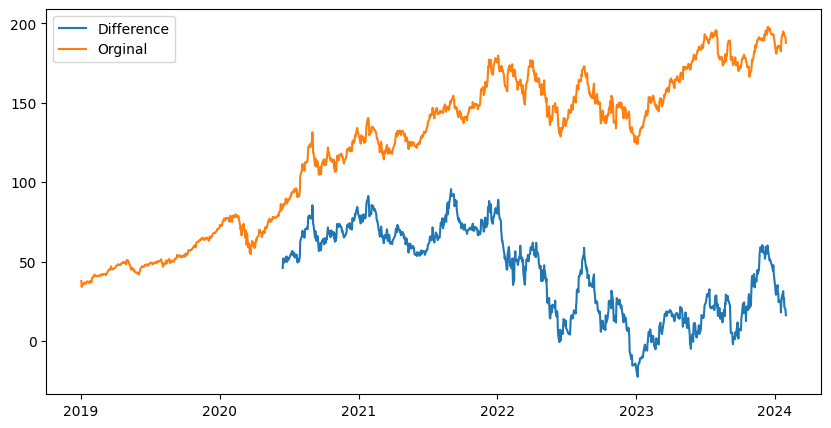

In [11]:
plt.figure(figsize=(10,5))
plt.plot(diff.index,diff,label = 'Difference')
plt.plot(data1.index,data1['Adj Close'], label = 'Orginal')
plt.legend()

##### Comment : Difference transform is also volatile --> not likely to have a strong seasonality characteristic

### STATIONARY

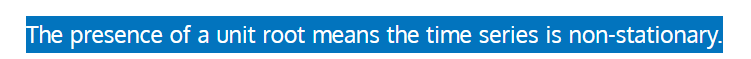
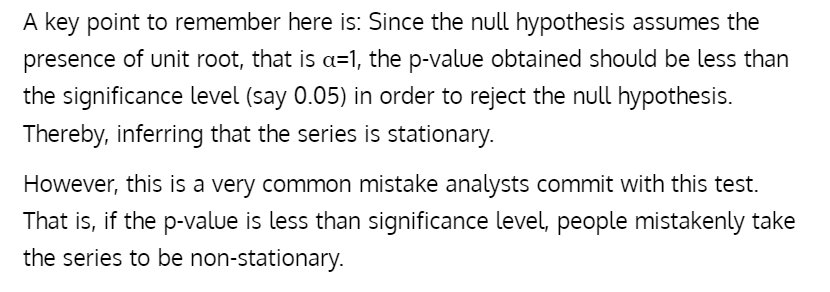

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# ADF TEST FOR STATIONARY
def stationary_check(df):
    result = adfuller(df)
    print(f'ADF Stats: {result[0]}')
    print(f'p-value : {result[1]}')
    for key, val in result[4].items():
        print(f'Critical values : {key},{val}')
    return


In [14]:
stationary_check(adj_df)

ADF Stats: -1.261018911627535
p-value : 0.646812275201447
Critical values : 1%,-3.4354811617704835
Critical values : 5%,-2.8638059672175684
Critical values : 10%,-2.5679764210546328


In [15]:
stationary_check(adj_log)

ADF Stats: -2.2904942861333994
p-value : 0.17505208394531974
Critical values : 1%,-3.4355176558157616
Critical values : 5%,-2.8638220694163588
Critical values : 10%,-2.5679849962931267


##### comment: p-value larger than 0.05 --> reject H0 --> series is non stationary --> decide the order of differencing

#### DIFFERENCING

In [16]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [17]:
# diff1 = adj_df.diff()
def acf_plot(original,order,lag):
    fig,ax = plt.subplots(2,1,figsize=(12,8))
    diff_df = original.diff(periods = order).dropna()
    ax[0].plot(diff_df)
    ax[0].set_title('Difference')

    smt.graphics.plot_acf(diff_df,lags=lag,ax = ax[1])
    plt.tight_layout()


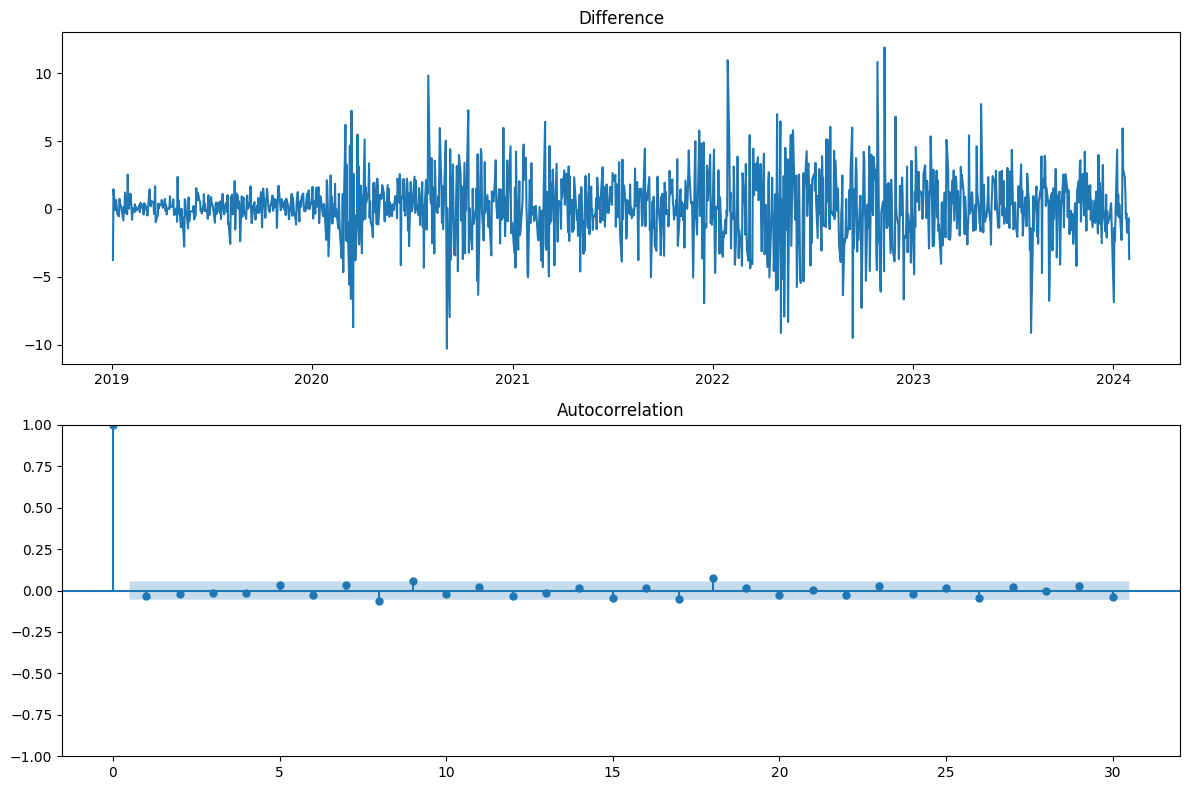

In [18]:
acf_plot(adj_df,1,30)

In [19]:
from pmdarima.arima.utils import ndiffs

In [20]:
ndiffs(adj_log, test="adf",max_d=40)

1

##### Comment: the order of differencing is 1 

### PACF (determining the order of an AR(p) process. Describes the direct relationship between an observation and its lag.)

In [21]:
def pacf_plot(orginal,order,lag):
    fig,ax = plt.subplots(2,1,figsize=(12,8))
    diff_df = orginal.diff(periods = order).dropna()
    ax[0].plot(diff_df)
    ax[0].set_title('Difference')

    smt.graphics.plot_pacf(diff_df,lags=lag,ax=ax[1])
    plt.tight_layout()

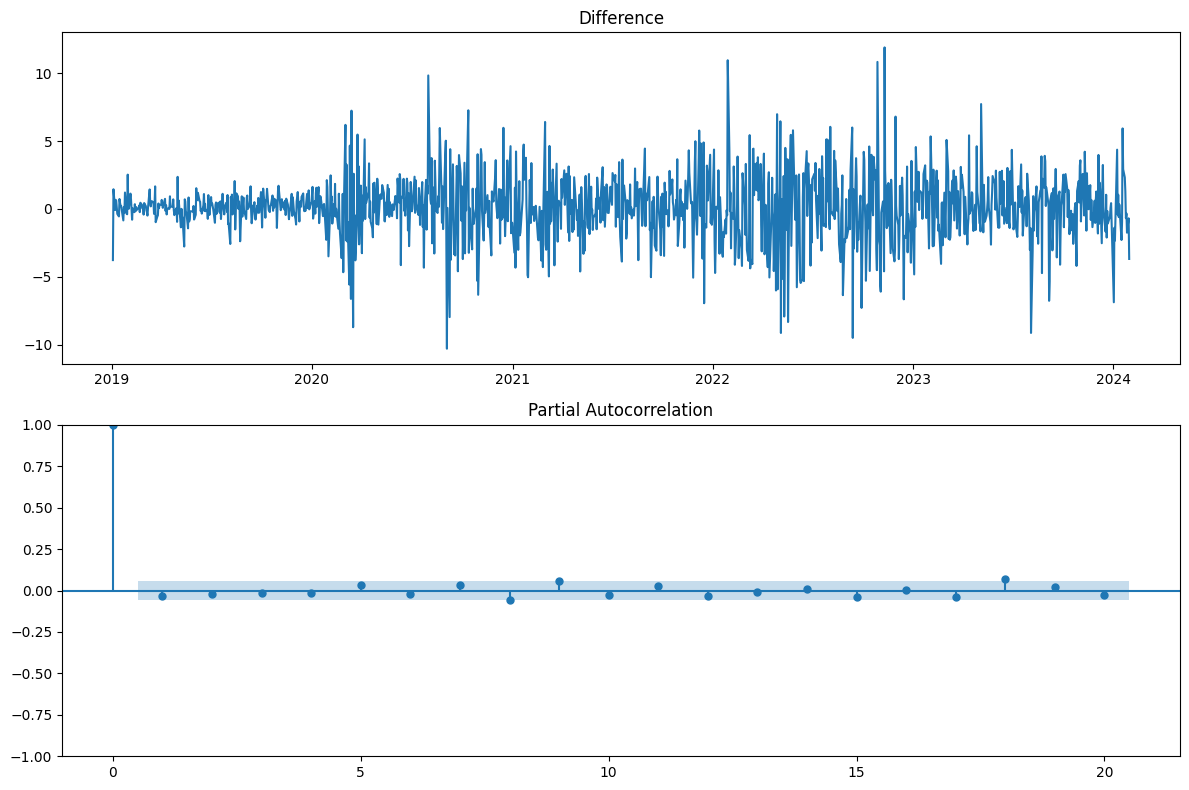

In [22]:
pacf_plot(adj_df,1,20)

#### Comment: The PACF lag of 8 or lag 18 might be outside the significance line  --> AR(8) or AR(18) or AR(0)

### MOVING AVERAGE MA(q)


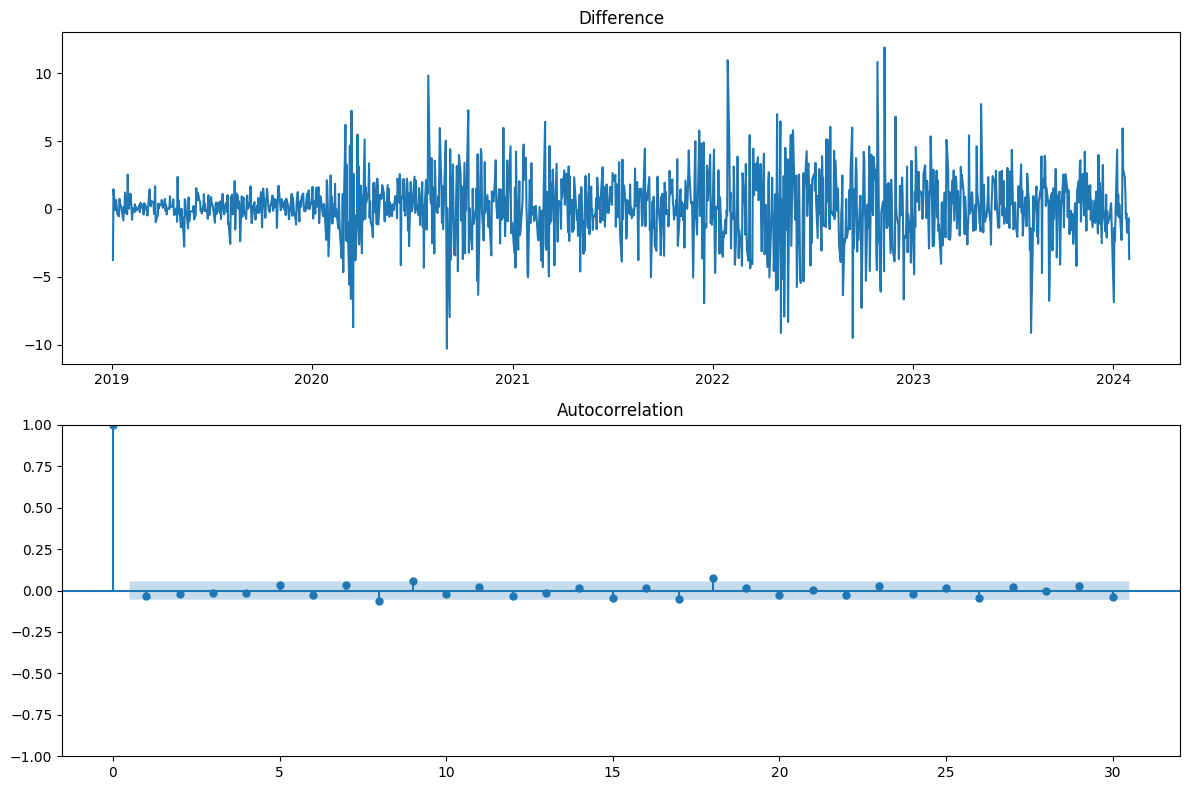

In [23]:
acf_plot(adj_df,1,30)

##### MA(0) - MA(8) hay MA(18) ???

##### Run ADF test on differenced time series

In [24]:
stationary_check(adj_df.diff(periods = 1).dropna())

ADF Stats: -36.96884459980037
p-value : 0.0
Critical values : 1%,-3.435485191190367
Critical values : 5%,-2.8638077451204973
Critical values : 10%,-2.5679773678766913


#### MODELLING

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [26]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(adj_df,order = (0,1,0))
re = model.fit()
print(re.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1278
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -2914.189
Date:                Fri, 26 Apr 2024   AIC                           5830.378
Time:                        10:55:54   BIC                           5835.530
Sample:                             0   HQIC                          5832.312
                               - 1278                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         5.6195      0.147     38.200      0.000       5.331       5.908
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):               361.61
Prob(Q):                              0.21   Pr

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<Axes: xlabel='Date'>

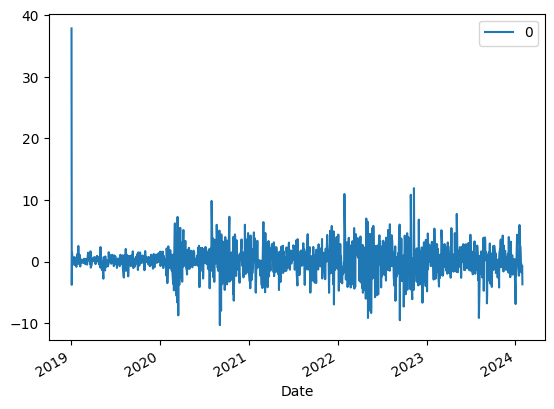

In [27]:
residual = pd.DataFrame(re.resid)
residual.plot()

In [28]:
from pmdarima.arima import auto_arima

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5845.545, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16093.636, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=14357.551, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5846.014, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5847.090, Time=0.74 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12836.817, Time=0.97 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.41 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5844.218, Time=0.82 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=5829.651, Time=1.45 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=5844.147, Time=1.01 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=5832.907, Time=1.48 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=5832.383, Time=1.53 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=5846.156, Time=1.09 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AI

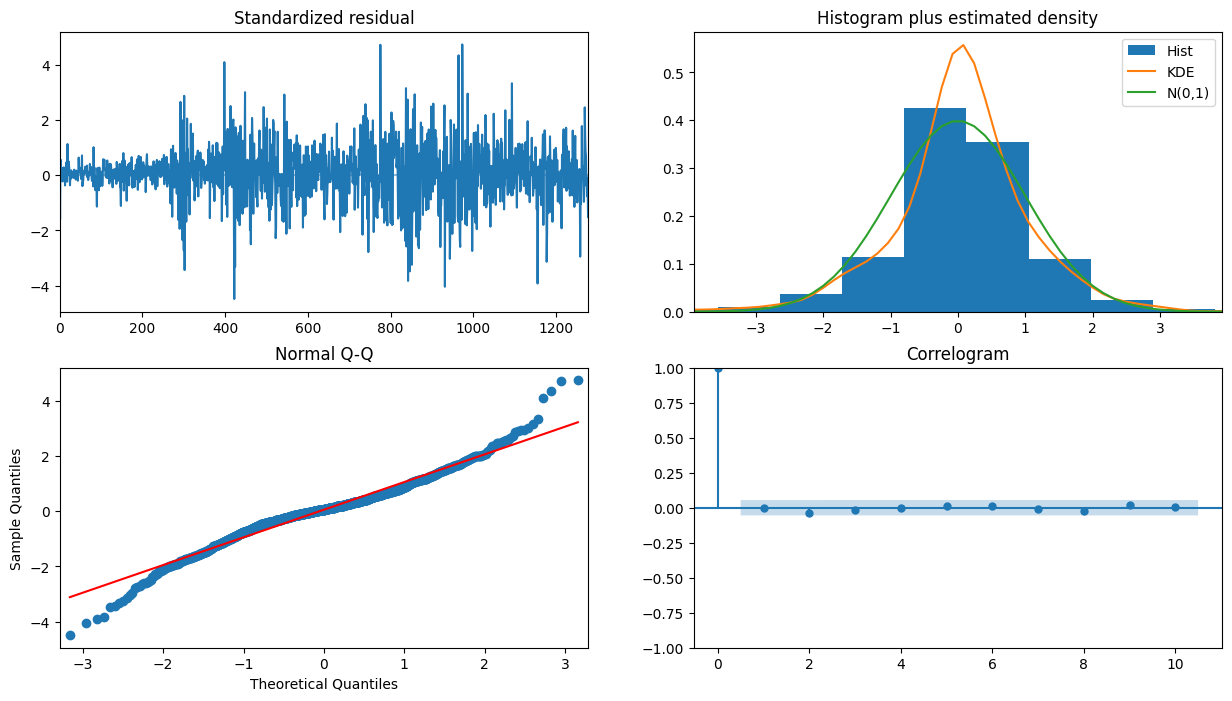

In [29]:
auto = auto_arima(adj_df,start_p=1,start_q=1,test='adf',max_p = 5, max_q = 5,d = 0,
                  m=1,seasonal=False,start_P=1,start_Q=1,stationary = False,trace = True,error_action='ignore',
                  suppress_warnings=True,stepwise=True)
print(auto.summary())
auto.plot_diagnostics(figsize=(15,8))
plt.show()

In [42]:
best_model = ARIMA(adj_df,order=(3,1,2)).fit()
#print(best_model.summary())

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-st

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


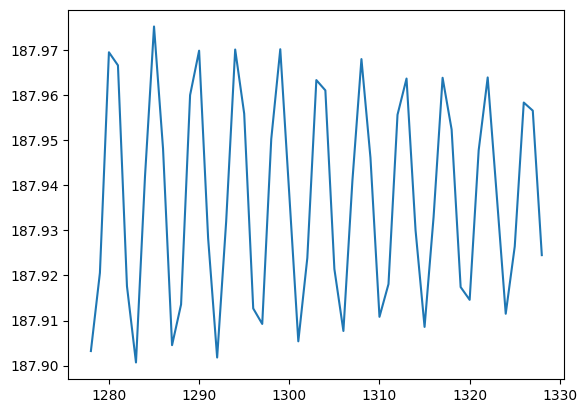

In [52]:
plt.plot(best_model.predict(start = len(adj_df), end = len(adj_df)+ 50))

In [31]:
test = pd.read_csv('AAPL_test.csv')
test.shape

(50, 7)

In [32]:
data.shape

(1278, 7)

In [33]:
test['Date'] = pd.to_datetime(test['Date'])
test_adj = test.set_index('Date')[['Adj Close']]

In [34]:
merge = pd.concat([adj_df,test_adj],axis = 0, ignore_index=True)

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


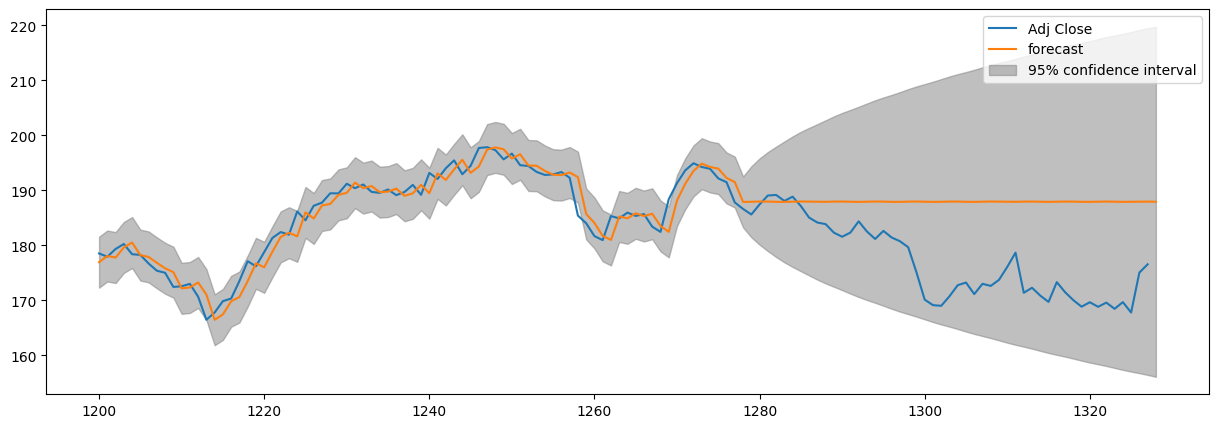

In [54]:
from statsmodels.graphics.tsaplots import plot_predict
fig,ax = plt.subplots(figsize = (15,5))
#ax = test_adj.plot(ax=ax)
#adj_df[900:1279].plot(ax=ax)
merge[1200:1328].plot(ax = ax)
plot_predict(best_model,start = 1200,end = 1328,ax = ax,dynamic = False)
plt.show()

In [36]:
pred = best_model.forecast(50,alpha = 0.05)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(test_adj, pred)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_adj, pred)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_adj, pred))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(pred - test_adj)/np.abs(test_adj))
print('MAPE: '+str(mape))

MSE: 161.81886863970553
MAE: 10.876735522200374
RMSE: 12.720804559449277
MAPE: nan


c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [37]:
pred = best_model.forecast(steps=50)
cf = best_model.get_forecast(steps=50).conf_int()
se = best_model.bse

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [61]:
pd.DataFrame(data={'Fore': best_model.forecast(steps=50), 'Pred': best_model.predict(start = len(adj_df), end = len(adj_df) + 50)})

c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\KyThuat88\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Fore,Pred
1278,187.903230,187.903230
1279,187.920574,187.920574
1280,187.969514,187.969514
1281,187.966614,187.966614
1282,187.917618,187.917618
1283,187.900697,187.900697
1284,187.941973,187.941973
1285,187.975233,187.975233
1286,187.948124,187.948124
1287,187.904538,187.904538


In [38]:
def inverse_difference(history, yhat, interval=1):
 return np.cumsum(yhat) + history.iloc[-interval]

In [39]:
rescale = pred + adj_df.iloc[-1].values

In [40]:
adj_df.values

array([[ 37.84503174],
       [ 34.07539368],
       [ 35.53004456],
       ...,
       [192.17477417],
       [191.48565674],
       [187.800354  ]])

In [41]:
pred_result = pd.DataFrame(pred).reset_index()